https://blog.csdn.net/great_yzl/article/details/119831771

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1、读取灰度图

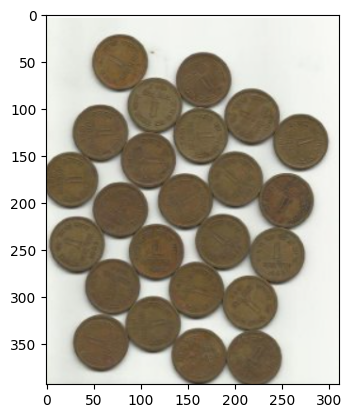

In [3]:
image = cv2.imread("../images/coin.png")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap="gray")

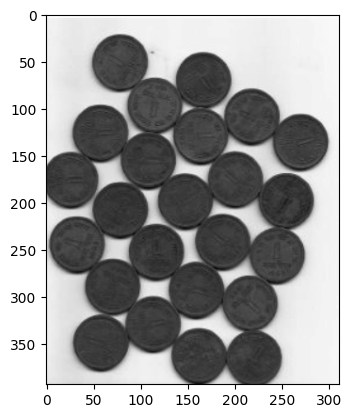

In [4]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")

## 2、把原图像转二值图

162.0


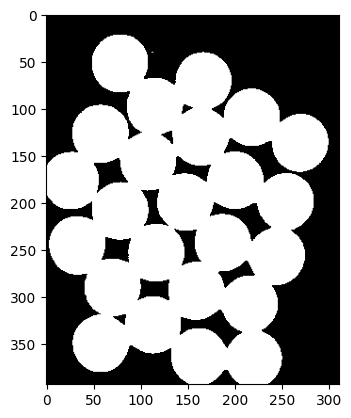

In [5]:
retval, binary = cv2.threshold(
    src=image_gray,
    thresh=0, # 阈值
    maxval=255, # dst图像中最大值 只对 THRESH_BINARY 和 THRESH_BINARY_INV 有效果
    type=cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU,
)
print(retval)
plt.imshow(binary, cmap="gray")

## 3、开运算去噪

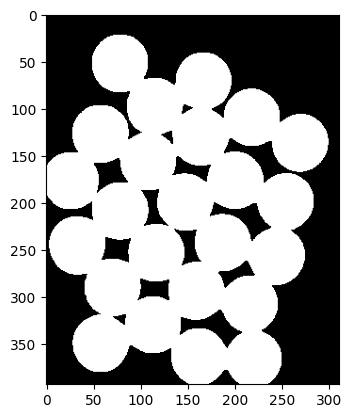

In [6]:
binary_open = cv2.morphologyEx(
    src=binary,
    op=cv2.MORPH_OPEN,
    kernel=np.ones((5, 5)),
    iterations=1,
)
plt.imshow(binary_open, cmap="gray")

## 4、确定背景区域（膨胀）（得到背景/最大连通域）

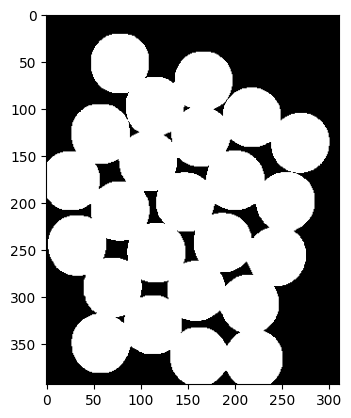

In [7]:
sure_bg = cv2.dilate(
    src=binary_open,
    kernel=np.ones((3, 3)),
    iterations=1,
)
plt.imshow(sure_bg, cmap="gray")

## 5、确定前景区域（距离变换） （分离）（得到种子/前景）

原理：距离变换，在二值图中把对象缩小，得到的就是原图的一部分，可以确定为前景。类似于分离。（不分离的话，可以不用距离变换，只用腐蚀就够了）

In [8]:
# 1、求对象最大宽度/长度（直径）
dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 5)
dist_transform

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

21.7


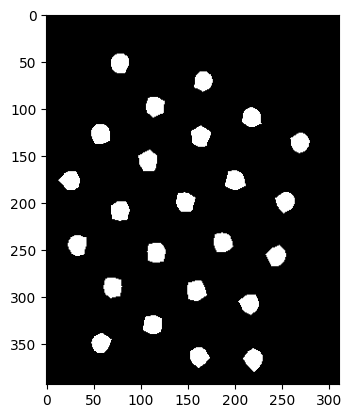

In [9]:
# 2、最长直径缩小一定程度，确定前景
#                           前景            阈值函数                      阈值 最大值 二值化方式
retval, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, cv2.THRESH_BINARY)
print(retval)
plt.imshow(sure_fg, cmap="gray")

## 6、找到未知区域（未知区域=背景-前景）

未知区域 = 确定的背景 - 确定的前景

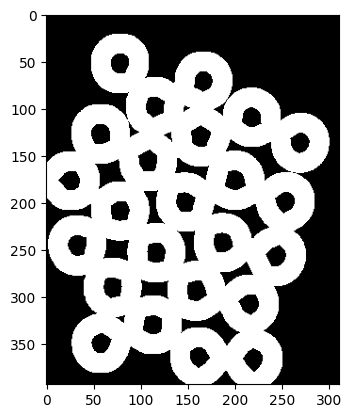

In [10]:
unknown = sure_bg - sure_fg
plt.imshow(unknown, cmap="gray")

## 7、根据种子标记最大连通域(可以计算个数)

根据种子标记最大连通域（大于1为内部区域，标记1为背景区域，0为未知区域）

25
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


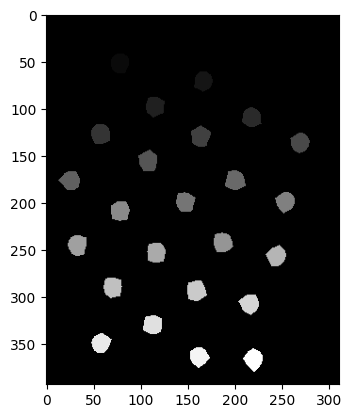

In [22]:
# 根据种子标记最大连通域（大于1为内部区域，标记1为背景区域，0为未知区域）
num_objects, markers = cv2.connectedComponents(sure_fg.astype(np.int8))  # 标记最大连通域
print(num_objects)          # 25个
print(np.unique(markers))   # 也是25个值,包含背景,除去背景有24个值,24个硬币
plt.imshow(markers, cmap="gray")

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


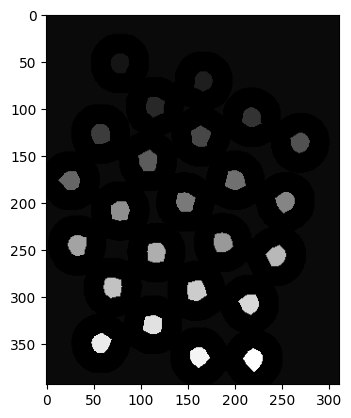

In [23]:
markers = markers + 1               # 最大连通域标记为1（背景）
print(np.unique(markers))
markers[unknown == 255] = 0         # 未知区域标记为0
print(np.unique(markers))
plt.imshow(markers, cmap="gray")

## 8、使用分水岭算法：合并种子和不确定区域、标记边界为-1

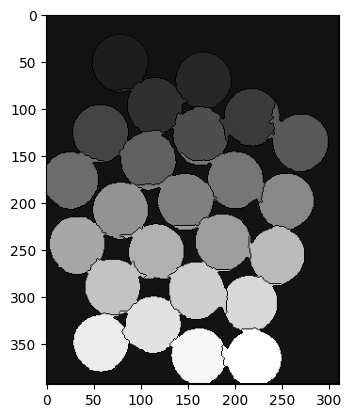

In [13]:
water_markers = cv2.watershed(image, markers)  # 分水岭算法（修改边界为-1）
plt.imshow(water_markers, cmap="gray")

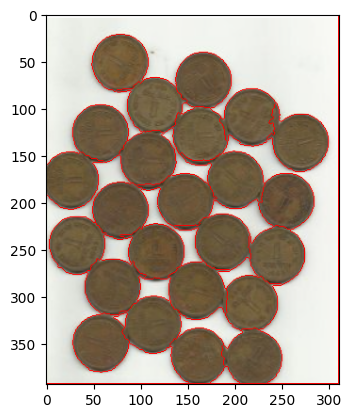

In [14]:
dst = image.copy()
dst[water_markers == -1] = [0, 0, 255]
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB), cmap="gray")